Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2023-11-23 18:26:00.939848: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 18:26:00.991462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 18:26:00.991504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 18:26:00.992819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 18:26:01.001528: I tensorflow/core/platform/cpu_feature_guar

In [152]:
file_path = '../data/WHO-COVID-19-global-data.csv'
date_column = 'Date_reported'
target_column = 'New_deaths'
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column,'New_cases', 'Cumulative_cases']]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
date_time = pd.to_datetime(df.pop(date_column), format='%Y-%m-%d')
df.set_index(date_time, inplace=True)


In [153]:
df.head()

,New_deaths,New_cases,Cumulative_cases
Date_reported,,,
2020-01-03,0,0,0
2020-01-04,0,3,3
2020-01-05,3,-1,2
2020-01-06,0,3,5
2020-01-07,0,0,5


In [154]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
New_deaths,1420.0,4.916382e+03,4.869881e+03,-3179.0,746.0,4517.0,7.720250e+03,57889.0
New_cases,1420.0,5.437792e+05,8.657419e+05,-1.0,93110.5,350797.0,5.870945e+05,8401963.0
Cumulative_cases,1420.0,3.656805e+08,2.941915e+08,0.0,77590340.0,270009407.5,6.395637e+08,772166517.0


In [173]:
WINDOW_SIZE = 16
num_features = df.shape[1]

In [174]:
def df_to_X_y(df, window_size=WINDOW_SIZE):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [175]:
temp = df[target_column]
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((1404, 16, 1), (1404,))

In [176]:
X_train1, y_train1 = X1[0:int(n*0.7)], y1[0:int(n*0.7)]
X_val1, y_val1 = X1[int(n*0.7):int(n*0.9)], y1[int(n*0.7):int(n*0.9)]
X_test1, y_test1 = X1[int(n*0.9):], y1[int(n*0.9):]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((993, 16, 1), (993,), (285, 16, 1), (285,), (126, 16, 1), (126,))

In [177]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

def compile_and_fit(model, X, y, validation_data, learing_rate = 0.001,expochs = 20, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learing_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(X, y, epochs=expochs,
                      validation_data=validation_data,
                      callbacks=[early_stopping])
  return history, model

def fit_lstm(X, y, batch_size, nb_epoch, neurons, validation_data, learning_rate = 0.001):
# def fit_lstm(neurons, window):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

    model = Sequential()
    model.add(InputLayer((WINDOW_SIZE, 1)))
    model.add(LSTM(neurons))
    model.add(Dense(num_features, 'relu'))
    model.add(Dense(1, 'linear'))
    # model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])
    # for i in range(nb_epoch):
    # model.fit(X, y, epochs=nb_epoch, batch_size=batch_size,  verbose=0, shuffle=False, validation_data=validation_data, callbacks=[early_stopping])
    # model.reset_states()
    return compile_and_fit(model, X, y, validation_data, expochs=nb_epoch, learing_rate=learning_rate)
# model1 = Sequential()
# model1.add(InputLayer((5, 1)))
# model1.add(LSTM(64))
# model1.add(Dense(8, 'relu'))
# model1.add(Dense(1, 'linear'))

# model1.summary()

In [178]:
history, model1=fit_lstm(X_train1, y_train1, neurons=32, nb_epoch=100, batch_size=16, validation_data=(X_val1, y_val1))

Epoch 1/100
32/32 [==============================] - 2s 21ms/step - loss: 64039088.0000 - mean_absolute_error: 6603.5327 - val_loss: 15278145.0000 - val_mean_absolute_error: 1411.2251
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 64032992.0000 - mean_absolute_error: 6603.0640 - val_loss: 15276657.0000 - val_mean_absolute_error: 1410.6580
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 64017932.0000 - mean_absolute_error: 6601.9409 - val_loss: 15272594.0000 - val_mean_absolute_error: 1409.2142
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 64000708.0000 - mean_absolute_error: 6600.6323 - val_loss: 15268767.0000 - val_mean_absolute_error: 1407.8035
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 63980516.0000 - mean_absolute_error: 6599.1392 - val_loss: 15265063.0000 - val_mean_absolute_error: 1406.4485
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 63959752.00

In [181]:
train_predictions = model1.predict(X_test1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test1})
train_results

4/4 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,145.581360,25
1,145.658997,20
2,148.358109,26
3,145.911804,532
4,276.006134,43
...,...,...
121,155.500076,15
122,149.884201,32
123,141.709061,0
124,148.763565,0


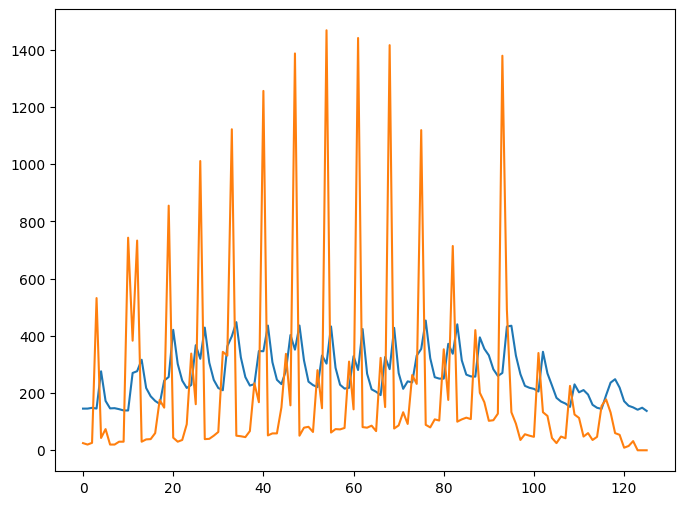

In [182]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])